<a href="https://colab.research.google.com/github/meixinzhang/rigid-moving-objects/blob/main/rigid-moving-object.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Some Title

Meixin Zhang, 

At the top, the notebook should have a clear title, your name,

### *Abstract*

a separate cell with a concise two-three paragraph abstract outlining the high-level goal and discussing well-motivated methodology of the project. 


### Team Members and Contributions

This cell should contain an itemized list of all team members. Each item (bullet) should start with a name and detail this person's contributions. 

- Meixin: 


### Code Libraries

You should also have a separate cell titled code libraries acknowledging all external code libraries "essential" for your project. You should explain the importance of each such library for your project. 

If these libraries are not installed with the default anaconda package, provide installation instructions/links or include the necessary files in extlibs subdirectory. 

If needed, for better organization and clarity of your project you can write your own code libraries that should be summarized in this section as well. The corresponding (.py) files should be included in mylibs subdirectory. For group projects, you can refer to your team's libraries in the earlier "contributions" section. At the bottom of your notebook, you should include a cell with two-three paragraphs summarizing the conclusions of your project.


In [1]:
# Packages
import numpy as np
import numpy.linalg as la
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import plot_matches
from skimage.transform import EssentialMatrixTransform
from skimage.color import rgb2gray

# TODO: REPLACE RANSAC WITH UFL
from skimage.measure import ransac

# Our Libraries 
from mylibs.structure_from_motion_lib import (
    get_matched_keyppoints, 
    matchedpoints_to_pairpoints, 
    camera_calib_nomalization,
    get_epipolar_lines,
    P_from_E,
    Afrom2pts,
    generate_X_from_A,
    get_proj_pts,
    #estimate_ufl,
)

## Implementation

Unsupervised detection and segmentation of (multiple) rigidly moving objects. 

You can detect multiple fundamental matrices while matching sparse features (Topics 6-7) and integrate these into loss functions for dense segmentation (topic 9). Essentially, this can be implemented as a combination of methods in HW3 and HW4. You can use any (pairs of) images for this project

Different parts of an image going through different kinds of movements (different essential/fundamental matrices)  - UFL

Use RANSAC/UFL for inlier matches multiple times, then find different fundamental matrices from that. Generate points from the surface based on the matrices. Ideally these should be on the same objects(A2)

Use the generated points (on the same reconstructed surfaces) as points that are ground truth, come up with the loss function (?) (A4)

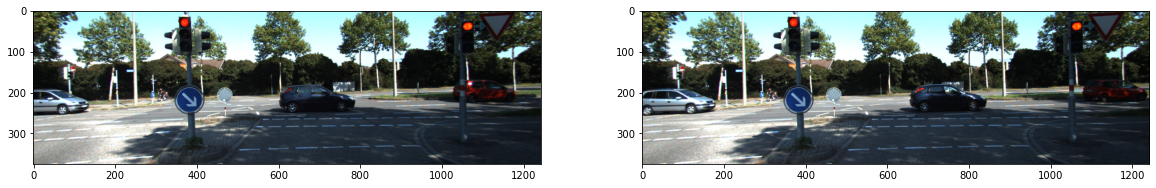

In [2]:
%matplotlib inline

# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)
imL = image.imread("images/car1_left.png")
imR = image.imread("images/car1_right.png")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

# using K_02 from calibration.txt
K = 1.0e+02 * np.array([[9.597910,        0, 6.960217],
                        [       0, 9.569251, 2.241806],
                        [       0,        0,    0.010]])

plt.figure(0,figsize = (20, 8))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()

## Structure from Motion Using UFL and Epipolar Geometry

#### Step 1: Feature Detection and Matching

Detect corners on the pictures and match using BRIEF descriptor.

the number of features in images 1 and 2 are   249 and   249
the number of matches is 199


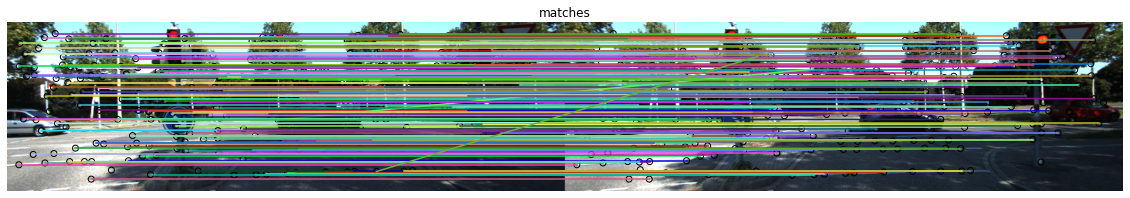

In [3]:
# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL, keypointsR, matchesLR = get_matched_keyppoints(imLgray, imRgray)

fig = plt.figure(2, figsize = (20, 8))
axA = plt.subplot(111)
axA.set_title("matches")
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

#### Step 2: Camera Normalization and Essential Matrix estimation using UFL

Recall that normalization of camera in the two images is given by multiplying the points by $K^{-1}$.


the number of inliers is 185
[ 3.  3.  0.  1.  0.  3.  1.  2.  0.  0.  3.  3.  3.  0.  0.  3.  1.  3.
  3.  2.  3.  3.  2.  0.  1. -1.  3.  0.  1.  1.  3.  1.  0.  0.  0.  2.
  0.  0.  2.  3.  0.  0.  0.  1.  1.  0.  0. -1.  2.  3.  1.  0.  0.  0.
  0.  0.  3.  2.  0.  0.  3.  2.  0.  0.  3.  2.  0.  0.  3.  2.  1.  0.
  1.  1.  1.  2.  1.  1.  2.  1.  0.  2.  1.  0.  3.  3.  2.  2.  1.  1.
  3. -1.  1.  1.  1.  1.  1.  1.  0.  1.  2.  0.  0.  1.  0.  1.  3.  2.
  0.  1.  0.  0.  0.  3.  0.  1.  0.  1.  3.  2.  1.  1.  1.  3.  0.  0.
 -1.  2.  4.  0.  0.  2.  0.  4.  0.  0.  1.  0.  0.  0.  0.  3.  0.  2.
  1.  3.  1.  4.  0.  1.  0.  2. -1.  0. -1.  0.  0.  1.  4.  3.  4.  4.
  0.  0.  4.  0.  2. -1.  0.  4. -1.  0.  0.  1.  0.  0.  4.  0.  2.  0.
  2.  0.  1.  0.  2.  3.  2.  1. -1. -1.  1. -1.  2.  1.  0.  0.  0. -1.
  1.]
the number of ufl inliers is 187


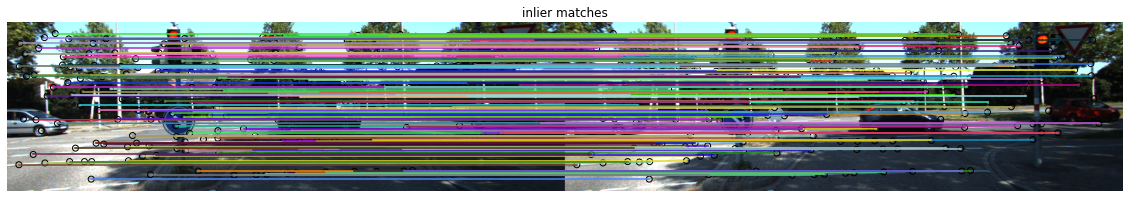

In [118]:
def estimate_ufl (src_pts, dst_pts, K = 100, gamma = 0.01, T = 1e-20) :
    """
    Estimates a homography from src_pts to dst_pts using the UFL method.
    K is the number of initial points to choose from
    """
    assert len(src_pts) == len(dst_pts)
    num_pts = len(src_pts)

    # Initial set of models
    models = []

    # Randomly choose K lines
    for i in range(K) :
        # Randomly choose 8 points
        random_idx = np.random.choice(num_pts, 8, replace=False)
        src_random = src_pts[random_idx]
        dst_random = dst_pts[random_idx]
        # Fit a homography through them
        EMT = EssentialMatrixTransform()
        if EMT.estimate(src_random, dst_random) :
            models.append(EMT.params)
            # print(np.diag(np.hstack((dst_random, np.ones((8,1)))) @ EMT.params @ np.vstack((src_random.T, np.ones(8)))))

    # Remove duplicates in the initial set of models
    models = np.unique(np.array(models), axis=0)

    # Nearest model for each point
    nearest_models = np.zeros(num_pts)-1
    # Nearest distances for each point
    distances = np.zeros(num_pts)+np.Inf

    # Homogeneous coordinates
    dst_hom = np.hstack((dst_pts  , np.ones((num_pts,1))))
    src_hom = np.vstack((src_pts.T, np.ones(num_pts)))

    # Find nearest model for each point
    for i in range(len(models)) :
        # Distances for each point to the current model
        model_dists = np.diag(dst_hom @ models[i] @ src_hom)
        # Update points where the current model has smaller distance
        nearest_models[np.where((model_dists < distances) & (model_dists < T))] = i
        # Update distances
        distances = np.minimum(distances, model_dists)

    #print(distances)
    #print(nearest_models)

    # The list of resulting models
    result_models = []
    # Match each point to a model index. An index of -1 means outlier.
    pts_to_models = np.zeros(num_pts)-1

    # Readjust parameters for each model to better fit the inliers
    for i in range(len(models)) :
        # The inlier index
        inlier_idx = np.where(nearest_models == i)[0]
        # Skip if no inliers
        if len(inlier_idx) < 8 :
            continue
        # Inlier points
        src_inliers = src_pts[inlier_idx]
        dst_inliers = dst_pts[inlier_idx]
        # Make the model more precise by re-estimating using only the inliers
        EMT = EssentialMatrixTransform()
        if EMT.estimate(src_inliers, dst_inliers) :
            pts_to_models[inlier_idx] = len(result_models)
            result_models.append(EMT.params)

    return result_models, pts_to_models

ptsL_inv, ptsR_inv = matchedpoints_to_pairpoints(keypointsL, keypointsR, matchesLR)
# swapping columns using advanced indexing https://docs.scipy.org/doc/numpy/reference/arra
# This changes point coordinates from (y,x) in ptsL1/ptsR1 to (x,y) in ptsL/ptsR
ptsL, ptsR = ptsL_inv[:,[1, 0]], ptsR_inv[:,[1, 0]]

n_ptsL = camera_calib_nomalization(ptsL, K)
n_ptsR = camera_calib_nomalization(ptsR, K)

# TODO: REPLACE HERE RANSAC BY UFL
# robustly estimate essential matrix using normalized points and RANSAC
E_ufl_trans, E_ufl_models = estimate_ufl(n_ptsL, n_ptsR)
E_trans, E_inliers = ransac((n_ptsL, n_ptsR), EssentialMatrixTransform, min_samples=8, residual_threshold=0.0001, max_trials=5000)
num_inliers = np.sum(E_inliers)
print ('the number of inliers is {:2d}'.format(num_inliers))
print (E_ufl_models)
print ('the number of ufl inliers is {:d}'.format(len(np.where(E_ufl_models > -1)[0])))
# Singular values for E
E = E_trans.params

ind = np.ogrid[:n_ptsL.shape[0]]
EmatchesRansac = np.column_stack((ind[E_inliers],ind[E_inliers]))

fig = plt.figure(5,figsize = (20, 8))
axA = plt.subplot(111)
axA.set_title("inlier matches")
plt.gray()
# NOTE: function "plot matches" expects that keypoint coordinates are given as (y,x), that is (row, col)
plot_matches(axA, imL, imR, ptsL_inv, ptsR_inv, EmatchesRansac)
axA.axis('off')
plt.show()

#### Step 3: Epipolar Lines from E 

Recall that 

- given homogeneous normalized point $x^{n}_B$ in image B, a 3-vector $l_A^n$ describing the corresponding epipolar line of normalized points in image A is: $l_A^n= E x^{n}_B$

- given homogeneous normalized point $x^{n}_A$ in image A, a 3-vector $l_B^n$ describing the corresponding epipolar line of normalized points in image B is: $l_B^n= E^\top x^{n}_A$

- assuming line (3-vector) $l^n$ of normalized image points, a 3-vector representation $l$ for the line formed by the corresponding points on the real (unnormalized) camera image is $l= (K^{-1})^\top l^n$

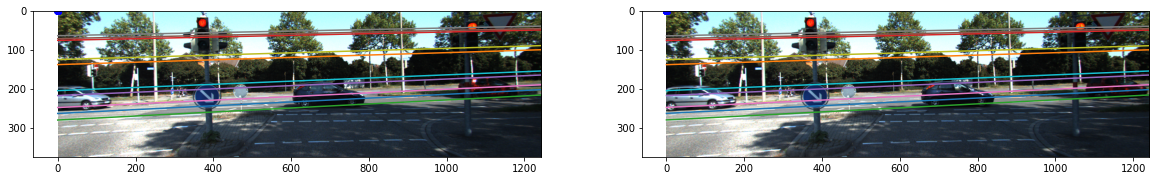

In [5]:
# Randomly select 10 matches (paris of features in two images) from the set of inliers for E
ind_sample = np.random.choice(ind[E_inliers], 10, replace = False)
# create an array of normalized points sampled in image 1 
n_ptsL_sample = n_ptsL[ind_sample,:]
n_ptsR_sample = n_ptsR[ind_sample,:]

# Indicate these matching features in image 1 and image 2
plt.figure(6,figsize = (20, 8))
ax61 = plt.subplot(121)
plt.imshow(imL)
plt.plot(n_ptsL_sample[:, 0], n_ptsL_sample[:, 1], 'ob')
ax62 = plt.subplot(122)
plt.imshow(imR)
plt.plot(n_ptsR_sample[:, 0], n_ptsR_sample[:, 1], 'ob')

epipolar_a_im1, epipolar_b_im1, epipolar_a_im2, epipolar_b_im2 = get_epipolar_lines(n_ptsL_sample, n_ptsR_sample, E, K)
# for each feature (in both images) draw a correspoindiung epipolar line in the other image
x_start, x_end = 0, 1242
epipolar_x = np.arange(x_start, x_end)

for a, b in zip(epipolar_a_im1, epipolar_b_im1):
    epipolar_y_im1 = a * epipolar_x + b               
    ax61.plot(epipolar_x, epipolar_y_im1)

for a, b in zip(epipolar_a_im2, epipolar_b_im2):
    epipolar_y_im2 = a * epipolar_x + b               
    ax62.plot(epipolar_x, epipolar_y_im2)

plt.show()

#### Step 8: Triangulation from the Essential Matrix

Using points from images, and the essential matrices, we can get the world coordinate systems consistent with the projection matrices of the two images.

##### In these 3D reconstruction steps you should use the world coordinate system consistent with the projection matrices estimated in step 7. In all steps you should obtain solutions for all four distinct cases of the second camera: $P_a$, $P_b$, $P_c$, $P_d$. First, step 8 is to Implement least squares (you can use $svd$ or $inv$ functions) for "triangulating" 3D points corresponding to pairs of matched features that are inliers for estimated $E$ (i.e. consistent with the epipolar geometry). Make sure to use normalized coordinates for image points. Then (step 9) you will compute camera positioning (optical centers and calibrated image centers as 3D points) in the world coordinate system. This is used in data visualsation step 10 (fully implemented). That step visulaizes in 3D both camera positions (red - optcal centers, green - image centers) and triangulated points (blue) for four possible cases of the second camera. You should identify one case when solution has 3D points in front of both cameras. In the last step 11 you will project 3D points onto each camera, convert to uncalibrated coordinates, and display these projected points (use red) together with the original features (use blue). Observe if the are red and blue points are close in each image.

Now we shall traverse each matched inliers to get all of the $X$s.

In [6]:
Xa_list = []
Xb_list = []
Xc_list = []
Xd_list = []

for indx in ind[E_inliers]:
    xa = n_ptsL[indx,:].flatten()
    xb = n_ptsR[indx,:].flatten()

    Aa, Ab, Ac, Ad = Afrom2pts(xa, xb, E)
    Xa, Xb, Xc, Xd = generate_X_from_A(Aa, Ab, Ac, Ad)

    Xa_list.append(Xa)
    Xb_list.append(Xb)
    Xc_list.append(Xc)
    Xd_list.append(Xd)

Xa = np.vstack(Xa_list)
Xb = np.vstack(Xb_list)
Xc = np.vstack(Xc_list)
Xd = np.vstack(Xd_list)

#### Step 9: Camera positioning in 3D  (four solutions)
##### In this step you will compute location of each cameras' optical center and its (calibrated) image center as points in 3D (world coordinate system). The next step 10 visulaizes the computed cameras' optical centers in red and image centers in green.

In [7]:
# camera's optical centers (for pair of cameras) as points in 3D world coordinate system
# 2x3 matrices: two rows with 3D point coordinates for the first and second camera

# Recall the definition of Ps
# Pa = np.column_stack((R1, T1))
# Pb = np.column_stack((R1, T2))
# Pc = np.column_stack((R2, T1))
# Pd = np.column_stack((R2, T2))

# From problem 2
R1_inv = la.inv(R1)
R2_inv = la.inv(R2)
Ca = np.stack((np.array([0, 0, 0]), np.matmul(R1_inv, -T1)))
Cb = np.stack((np.array([0, 0, 0]), np.matmul(R1_inv, -T2)))
Cc = np.stack((np.array([0, 0, 0]), np.matmul(R2_inv, -T1)))
Cd = np.stack((np.array([0, 0, 0]), np.matmul(R2_inv, -T2)))

# calibrated/normalized image centers (for pair of cameras) as points in 3D world coordinate system
# 2x3 matrices: two rows with 3D po### Step 9: Cameras positions/orientations in 3D  (four solutions)int coordinates for the first and second camera
Qa = np.stack((np.array([0, 0, 1]), np.matmul(R1_inv, np.array([0, 0, 1])-T1)))
Qb = np.stack((np.array([0, 0, 1]), np.matmul(R1_inv, np.array([0, 0, 1])-T2)))
Qc = np.stack((np.array([0, 0, 1]), np.matmul(R2_inv, np.array([0, 0, 1])-T1)))
Qd = np.stack((np.array([0, 0, 1]), np.matmul(R2_inv, np.array([0, 0, 1])-T2)))

print (Cc)
print (Qc)

NameError: name 'R1' is not defined

#### Step 10: 3D visualization of cameras and triangulated points (four solutions)

In [ ]:
# visualization part
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(10,figsize = (10, 10))

ax10_1 = plt.subplot(221, projection='3d')
plt.title('Solution a')
ax10_1.scatter(Xa[:,0],Xa[:,1],Xa[:,2], c='b', marker='p')
# ax10_1.scatter(Ca[:,0],Ca[:,1],Ca[:,2], c='r', marker='p')
# ax10_1.scatter(Qa[:,0],Qa[:,1],Qa[:,2], c='g', marker='p')

ax10_2 = plt.subplot(222, projection='3d')
plt.title('Solution b')
ax10_2.scatter(Xb[:,0],Xb[:,1],Xb[:,2], c='b', marker='p')
# ax10_2.scatter(Cb[:,0],Cb[:,1],Cb[:,2], c='r', marker='p')
# ax10_2.scatter(Qb[:,0],Qb[:,1],Qb[:,2], c='g', marker='p')

ax10_3 = plt.subplot(223, projection='3d')
plt.title('Solution c')
ax10_3.scatter(Xc[:,0],Xc[:,1],Xc[:,2], c='b', marker='p')
# ax10_3.scatter(Cc[:,0],Cc[:,1],Cc[:,2], c='r', marker='p')
# ax10_3.scatter(Qc[:,0],Qc[:,1],Qc[:,2], c='g', marker='p')

ax10_4 = plt.subplot(224, projection='3d')
plt.title('Solution d')
ax10_4.scatter(Xd[:,0],Xd[:,1],Xd[:,2], c='b', marker='p')
# ax10_4.scatter(Cd[:,0],Cd[:,1],Cd[:,2], c='r', marker='p')
# ax10_4.scatter(Qd[:,0],Qd[:,1],Qd[:,2], c='g', marker='p')

plt.show()

In [ ]:
# Randomly select N=50 matches (pairs of features in two images) from the set of inliers for E
N = 50
ind_sample2 = np.random.choice(num_inliers, N, replace = False)

# Indicate (E) inlier matches in image 1 and image 2
plt.figure(11,figsize = (10, 4))
ax11_1 = plt.subplot(121)
plt.imshow(imL)
plt.plot(ptsL[ind[E_inliers][ind_sample2], 0], ptsL[ind[E_inliers][ind_sample2], 1], 'ob')
ax11_2 = plt.subplot(122)
plt.imshow(imR)
plt.plot(ptsR[ind[E_inliers][ind_sample2], 0], ptsR[ind[E_inliers][ind_sample2], 1], 'ob')

# project reconstructed 3D points onto both images and display them in red color
Pw, Pa, Pb, Pc, Pd = P_from_E(E)
pts3D = Xa[ind_sample2]
ptsL_proj, ptsR_proj = get_proj_pts(Pw, Pa, pts3D, K)
ax11_1.plot(ptsL_proj[:,0], ptsL_proj[:,1], '.r')
ax11_2.plot(ptsR_proj[:,0], ptsR_proj[:,1], '.r')

plt.show()

## Conclusion


You should include a cell with two-three paragraphs summarizing the conclusions of your project.
